# Overfitting et dropout

Gestion du sur-apprentissage avec la suppression de la réponse de certains neurones.

## Overfitting

Lors de la réalisation précédente, on remarque qu'il y a une divergence entre les courbes d'entropie des jeux de test et d'entraînement. Cela n'affecte pas la précision du modèle, mais montre que l'entraînement n'a plus d'effet positif. Ceci est dû au fait que notre modèle a trop de degrés de liberté et a tendance à "sur-apprendre" sur le jeu d'entraînement. Pour éviter cela on utilise la technique du dropout qui supprime arbitrairement un certain taux de neurones à chaque passage.

<img src="overfitting.png"  style="width: 40%; height: 40%"/>

## Dropout

`tf.nn.dropout` permet d'appliquer cette solution de "suppression" de neurones. En réalité la valeur de sortie est mise à 0. Cette fonction s'applique en sortie d'une couche de neurones. On passe en paramètre `rate` qui indique la probabilité qu'un neurone soit supprimé (doit être = 0 lors de la phase de test).

<img src="dropout.png"  style="width: 40%; height: 40%"/>

## Reformulation du réseau neuronal à 5 couches

In [27]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [28]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train/255.
x_test  = x_test/255.
y_train = to_categorical(y_train, dtype='int8')
y_test  = to_categorical(y_test, dtype='int8')

train_size = x_train.shape[0] # Nombre de ligne de la matrice x_train
test_size  = x_test.shape[0]

In [29]:
#Nombre d'époques pour l'apprentissage:
n_epoch = 30

# Taille du batch d'entraînement:
batch_size = 100

# Incrément pour l'apprentissage
starter_learning_rate = 0.003
# taux de décroissance du pas d'apprentissage
decay_rate = 0.6
# Nombre d'époques à faire avant de changer de pas
decay_epoch = 5

In [30]:
X = tf.placeholder(tf.float32, shape=(None,28,28))
Xv = tf.reshape(X, [-1, 784])

# dropout_rate: probabilité qu'un neurone soit supprimé (doit être = 0 lors de la phase de test)
dropout_rate = tf.placeholder(tf.float32)

W1 = tf.Variable(tf.truncated_normal([784,200], stddev=0.1))
# Initialisation des biais 0.1
b1 = tf.Variable(tf.ones([200])/10)
Y1 = tf.nn.relu(tf.matmul(Xv,W1) + b1)
Y1d = tf.nn.dropout(Y1, rate=dropout_rate)

W2 = tf.Variable(tf.truncated_normal([200,100], stddev=0.1))
b2 = tf.Variable(tf.ones([100])/10)
Y2 = tf.nn.relu(tf.matmul(Y1d,W2) + b2)
Y2d = tf.nn.dropout(Y2, rate=dropout_rate)

W3 = tf.Variable(tf.truncated_normal([100,60], stddev=0.1))
b3 = tf.Variable(tf.ones([60])/10)
Y3 = tf.nn.relu(tf.matmul(Y2d,W3) + b3)
Y3d = tf.nn.dropout(Y3, rate=dropout_rate)

W4 = tf.Variable(tf.truncated_normal([60,30], stddev=0.1))
b4 = tf.Variable(tf.ones([30])/10)
Y4 = tf.nn.relu(tf.matmul(Y3d,W4) + b4)
Y4d = tf.nn.dropout(Y4, rate=dropout_rate)

W5 = tf.Variable(tf.truncated_normal([30, 10], stddev=0.1))
b5 = tf.Variable(tf.zeros([10]))
Ylogits = tf.matmul(Y4d,W5) + b5
Y = tf.nn.softmax(Ylogits)

In [31]:
Y_ = tf.placeholder(tf.float32, shape=(None,10))
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=Ylogits, labels=Y_)
cross_entropy = tf.reduce_sum(cross_entropy)

is_correct = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_epoch*train_size//batch_size, decay_rate, staircase=True)

# Optimisation
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(cross_entropy, global_step=global_step)

In [32]:
accuracy_train = []
accuracy_test = []
loss_train = []
loss_test = []
i_best = 0
accuracy_best = 0

In [33]:
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)
print('Epoque: ')

for i in range(n_epoch*train_size//100):
    epoch = (i*100)//train_size + 1
    
    # Chargement d'un batch d'images et de réponses correctes correspondantes
    batch_train_X  = x_train[(i*100)%train_size:((i+1)*100)%train_size]
    batch_train_Y_ = y_train[(i*100)%train_size:((i+1)*100)%train_size]
    # Dictionnaire de données en entrée
    train_data = {X: batch_train_X, Y_: batch_train_Y_, dropout_rate:0.25}

    # train
    sess.run(train_step, feed_dict=train_data)
    
    # Visualisation de la progression
    if not (i*100)%(train_size):
        #Affichage de l'évolution en ligne
        print(epoch, ' ', end='')
    if not i%50:
        # Pour le batch d'entraînement
        acc, loss  = sess.run([accuracy, cross_entropy], feed_dict=train_data)
        accuracy_train.append(acc)
        loss_train.append(loss/batch_size)
        
        # Pour le test: évaluation sur tout l'ensemble des données
        test_data = {X: x_test, Y_: y_test, dropout_rate:0}
        acc, loss = sess.run([accuracy, cross_entropy], feed_dict=test_data)
        accuracy_test.append(acc)
        loss_test.append(loss/test_size)
        if acc>accuracy_best:
            accuracy_best = acc
            i_best = i

Epoque: 
1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  

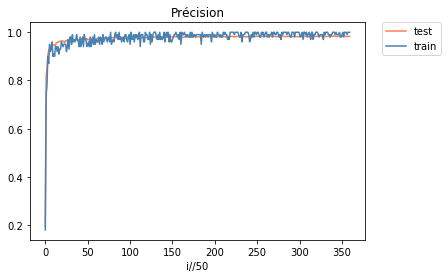

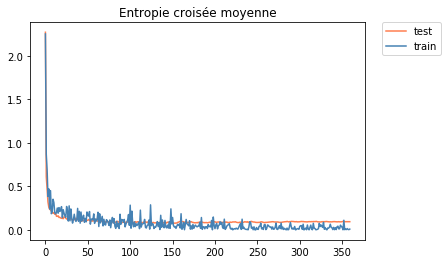

Best score for iteration 16200 	| Accuracy = 0.9841


In [34]:
# Représentation des résultats
# Précision
plt.plot(accuracy_test, c='coral', label='test')
plt.plot(accuracy_train, c='steelblue', label='train')
plt.xlabel('i//50')
plt.title('Précision')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
# Fonction de coût
plt.plot(loss_test, c='coral', label='test')
plt.plot(loss_train, c='steelblue', label='train')
plt.title('Entropie croisée moyenne')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
# Meilleur résultat sur un batch de test
print("Best score for iteration {} \t| Accuracy = {:.4f}".format(i_best, accuracy_best ))

In [35]:
sess.close()

La progression est plus chaotique, mais on n'observe plus de divergence entre l'entropie des deux jeux de données. Par contre il n'y a pas d'amélioration notable par rapport au test précédent.